## Load and set up images

In [1]:
%matplotlib widget
import numpy as np
import xarray as xr
import pandas as pd
import pywt
import matplotlib.pyplot as plt
from frat import frt

In [2]:
nc_fn = "E:/research_data/2022_harmonic_gravity_waves/preprocessed_images/bore_ex.nc"
ds = xr.open_dataset(nc_fn)
ds['time'] = pd.to_datetime(ds.time)

For easy examples 1 and 3, slice to [:, :2500].

In [3]:
easy_examples = [
    '2018-05-13T17:16',
    '2018-05-19T06:06',
    '2018-08-15T05:05',
    '2019-06-09T07:51',
    '2019-06-09T08:41',
    '2019-07-04T13:25',
    '2019-07-06T12:50',
    '2019-07-06T13:41',
    '2020-06-16T15:38',
]

In [4]:
ds.rad255.shape

(2304, 4064, 61)

In [5]:
img_array = ds.sel(time=easy_examples[0]).rad255.values

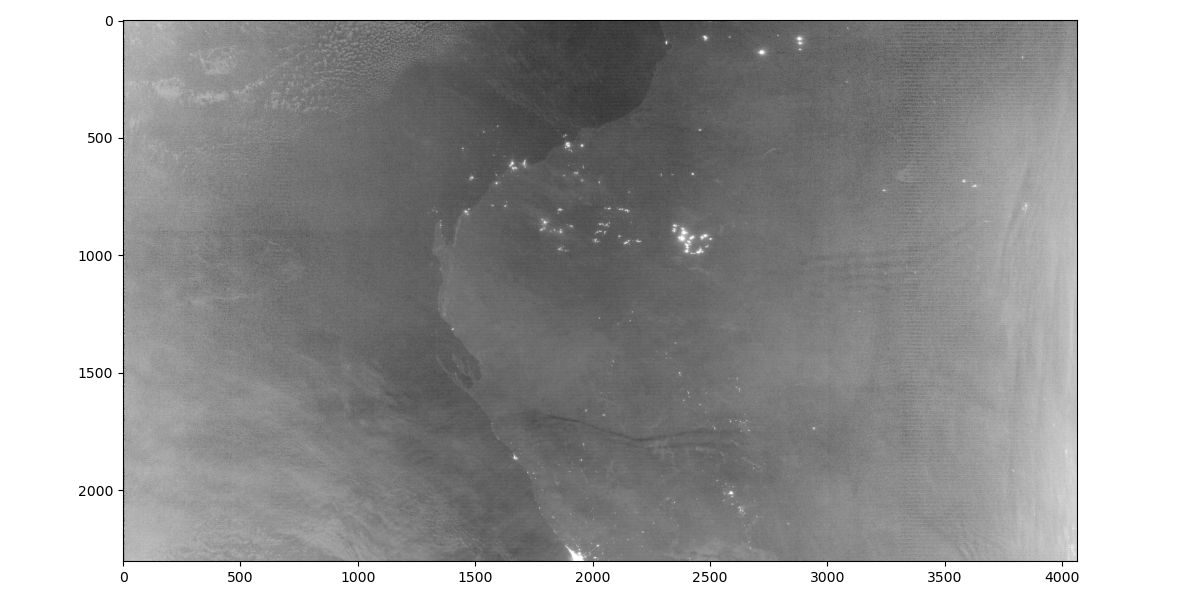

In [6]:
F, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.imshow(img_array, cmap='gray', clim=(0, 255))
F.tight_layout()

In [7]:
img_crop = img_array[1700:1849, 2300:2449, 0]

In [8]:
img_crop.shape

(149, 149)

In [9]:
test = np.float64(np.reshape(range(1, 10), (3, 3)))

In [10]:
test - test.mean()

array([[-4., -3., -2.],
       [-1.,  0.,  1.],
       [ 2.,  3.,  4.]])

In [11]:
test_frt = frt(folded=False)
sino = test_frt.fit_transform(test)
sino

array([[-5.19615242,  0.        ,  0.        , -1.73205081],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 5.19615242,  0.        ,  0.        ,  1.73205081]])

In [12]:
test_frt.n_vecs

[[0.0, 1.0], [-1.0, 1.0], [1.0, 1.0], [1.0, 0.0]]

In [13]:
test_frt.inv_transform(sino)

array([[-4., -3., -2.],
       [-1.,  0.,  1.],
       [ 2.,  3.,  4.]])

In [14]:
crop_frt = frt(folded=False)
frt_sino = crop_frt.fit_transform(img_crop)

In [15]:
frt_sino.shape

(149, 150)

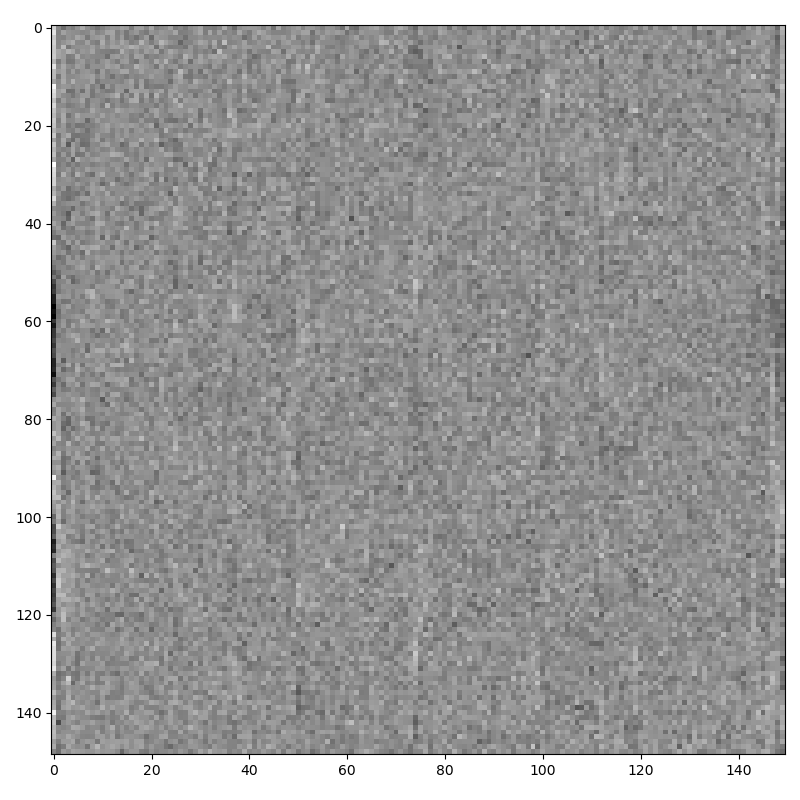

In [16]:
F, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(frt_sino, cmap='gray')
F.tight_layout()

In [17]:
img_crop_recon = crop_frt.inv_transform(frt_sino)

In [18]:
img_crop_recon.shape

(149, 149)

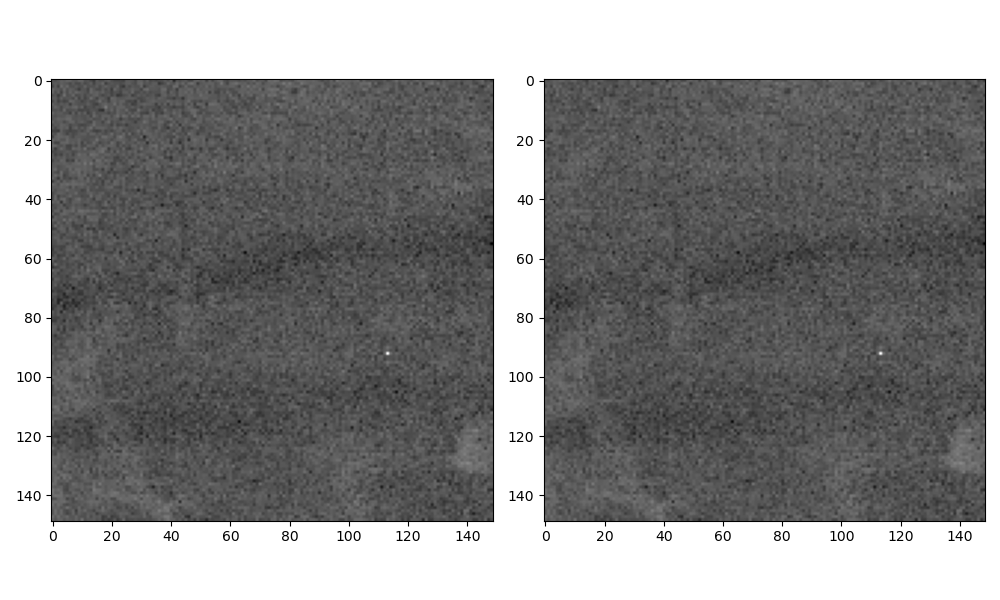

In [19]:
F, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].imshow(img_crop, cmap='gray')
ax[1].imshow(img_crop_recon, cmap='gray')
F.tight_layout()

In [20]:
err = img_crop - img_crop.mean() - img_crop_recon

In [21]:
err.min()

3.197442310920451e-13

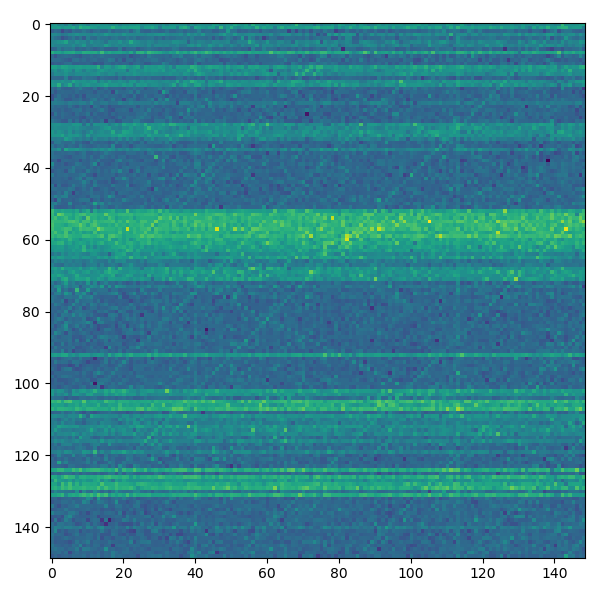

In [22]:
F, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(err, cmap='viridis')
F.tight_layout()

In [23]:
w = pywt.Wavelet('db3')
w.filter_bank

([0.03522629188570953,
  -0.08544127388202666,
  -0.13501102001025458,
  0.45987750211849154,
  0.8068915093110925,
  0.33267055295008263],
 [-0.33267055295008263,
  0.8068915093110925,
  -0.45987750211849154,
  -0.13501102001025458,
  0.08544127388202666,
  0.03522629188570953],
 [0.33267055295008263,
  0.8068915093110925,
  0.45987750211849154,
  -0.13501102001025458,
  -0.08544127388202666,
  0.03522629188570953],
 [0.03522629188570953,
  0.08544127388202666,
  -0.13501102001025458,
  -0.45987750211849154,
  0.8068915093110925,
  -0.33267055295008263])